In [561]:
from Bio.PDB import PDBParser
from Bio.Data.IUPACData import protein_letters_3to1
import networkx as nx

dProt = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

class Protein:
    def __init__(self, fileName, thresh):
        self.pdbFile = fileName
        self.eThresh = thresh
        self.struct = self.getStruct(self.pdbFile)
        self.graph, self.layers, self.seq = \
            self.genGraph(self.struct, self.eThresh)
        
    def getStruct(self, pdbFile):
        parser = PDBParser(QUIET=True)
        structure = \
            parser.get_structure("protein", pdbFile)
        return(structure)
        
    def genGraph(self, structure, eThresh):
        nodes, layers = [], []
        sequence = ""
        for model in structure:
            for chain in model:
                atoms = []
                for residue in chain:
                    for atom in residue:
                        if atom.name=="CA":
                            resName = residue.get_resname()
                            # print(resName)
                            sequence += dProt.get(resName, "X")
                            atoms.append(atom)
                            
                if len(atoms):
                    nodes.extend(atoms)
                    layers.append(len(atoms))
        edges = []
        for i in range(len(nodes)-1):
            for j in range(i+1, len(nodes)):
                dist = nodes[i]-nodes[j]
                if dist>0. and dist<=eThresh:
                    edges.append((i,j))
        g = nx.Graph(edges)
        return(g, layers, sequence)

    def getGraph(self):
        return(self.graph, self.layers, self.seq)

In [562]:
import numpy as np

class MultiCens:
    # implementation based on original MultiCens
    def __init__(self, g, layers, p, nIter):
        self.nodes = list(g.nodes())
        self.nodes.sort()
        self.edges = list(g.edges())
        self.layers = layers
        self.p = p
        self.nIter = nIter
        self.a, self.c = \
            self.getAdjMat(self.edges, self.layers)
        self.gc = self.computeGlobal()

    def getAdjMat(self, edges, layers):
        l1, l2 = layers[0], layers[1]
        adj = np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            adj[u, v] = 1.
            adj[v, u] = 1.
        adj = adj / np.sum(adj, axis=0)
        a, c = np.zeros(shape=(l1+l2, l1+l2)), \
                        np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            if (u<l1 and v<l1) or (u>=l1 and v>=l1):
                a[u, v] = adj[u, v]
                a[v, u] = adj[v, u]
            elif (u<l1 and v>=l1) or (v<l1 and u>=l1):
                c[u, v] = adj[u, v]
                c[v, u] = adj[v, u]
        return(a, c)
    
    def unitVector(self, vector):
        return(vector/np.linalg.norm(vector))
    
    def angleBetween(self, v1, v2):
        v1_u = self.unitVector(v1)
        v2_u = self.unitVector(v2)
        return(np.arccos(np.clip( \
                np.dot(v1_u, v2_u), -1.0, 1.0)))
    
    def computeLocal(self):
        n = self.a.shape[0]
        l = np.ones(n) / n
        unitNormal = np.copy(l)
        angle = float(0)
        for _ in range(self.nIter):
            lNew = (self.p*(self.a.dot(l))) + \
                            ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(l, lNew)
            if (angleNew==angle) or (angleNew==0):
                break
            l, angle = lNew, angleNew
        return(l)
    
    def computeGlobal(self):
        l = self.computeLocal()
        n = self.a.shape[0]
        g = np.ones(n) / n
        unitNormal = np.copy(g)
        angle = float(0)
        for _ in range(self.nIter):
            gNew = (self.p*((self.a+self.c).dot(g) + \
                self.c.dot(l))) + ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(g, gNew)
            if (angleNew==angle) or (angleNew==0):
                break
            g, angle = gNew, angleNew
        return(g)

    def getMultiCens(self):
        mc = (self.gc-self.gc.min()) /  \
                       (self.gc.max()-self.gc.min())
        mc = {x:mc[x] for x in self.nodes}
        return(mc)

In [563]:
from networkx.algorithms import community
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
rng = np.random.RandomState(42)

class MultiLayerCentrality:
    def __init__(self, g, layers, k):
        self.g = g
        self.nodes = list(g.nodes())
        self.nodes.sort()
        self.k = k
        self.layer1 = [i for i in range(layers[0])]
        self.layer2 = [i for i in range(layers[0],layers[0]+layers[1])]
        self.l1, self.l2 = layers[0], layers[1]
        print(self.l1, self.l2)
        self.l1g = g.subgraph(self.layer1)
        self.l2g = g.subgraph(self.layer2)
        # print(list(self.l1g.nodes))
        # print(list(self.l2g.nodes))
        self.scores = self.computeMLC()
    
    def compute_khop_jaccard_matrix(self, graph, k):
        n = graph.number_of_nodes()
        nodes = list(graph.nodes)
        nodes.sort()
        # print(nodes)
        # node_index = {node: idx for idx, node in enumerate(nodes)}  # Mapping of nodes to indices
        # Step 1: Compute k-hop neighbors for all nodes
        khop_neighbors = {}
        for node in nodes:
            neighbors = nx.single_source_shortest_path_length(graph, node, cutoff=k)
            # print(neighbors)
            # for x in graph.neighbors(354): print(x)
            khop_neighbors[node] = set(neighbors.keys()) - {node}
            # print(khop_neighbors[node])
            # break
        # print(khop_neighbors)
        # Step 2: Initialize similarity matrix
        jaccard_matrix = np.zeros((n, n))
        # Step 3: Compute pairwise Jaccard similarity
        for i, u in enumerate(nodes):
            for j, v in enumerate(nodes):
                if i <= j:  # Compute for upper triangular matrix
                    nu, nv = khop_neighbors[u], khop_neighbors[v]
                    intersection = len(nu & nv)
                    union = len(nu | nv)
                    similarity = intersection / union if union > 0 else 0.0
                    jaccard_matrix[i, j] = jaccard_matrix[j, i] = similarity
        # print(jaccard_matrix[:10])
        return jaccard_matrix

    def scale(self, Y):
        # Ensure Y is a dense numpy array
        # Y = np.array(Y)
        # Exclude diagonal elements
        Y_no_diag = Y.copy()
        np.fill_diagonal(Y_no_diag, 0)
        # Row-wise min-max normalization
        # min_vals = np.min(Y_no_diag, axis=1, keepdims=True)
        # max_vals = np.max(Y_no_diag, axis=1, keepdims=True)
        # delta = max_vals - min_vals
        # # Handle rows where min == max (all values are identical)
        # delta[delta == 0] = 1
        # Y_rescaled = (Y_no_diag - min_vals) / delta
        # Normalize by the maximum row sum
        row_sums = np.sum(Y_no_diag, axis=1, keepdims=True)
        max_row_sum = np.max(row_sums)
        Y_normalized = Y_no_diag / max_row_sum
        return Y_normalized
    

    def computeMLC(self):
        # l1g = self.l1g.copy()
        # communities = community.greedy_modularity_communities(l1g)
        # community_sets = [set(community) for community in communities]
        # for u, v in list(l1g.edges()):
        #     if not any(u in comm and v in comm for comm in community_sets):
        #         l1g.remove_edge(u, v)
        # self.l1g = l1g

        # l2g = self.l2g.copy()
        # communities = community.greedy_modularity_communities(l2g)
        # community_sets = [set(community) for community in communities]
        # for u, v in list(l2g.edges()):
        #     if not any(u in comm and v in comm for comm in community_sets):
        #         l2g.remove_edge(u, v)
        # self.l2g = l2g

        # def minimum_dominating_set(G):
        #     print(list(G.nodes()))
        #     prob = LpProblem("Minimum Dominating Set", LpMinimize)
        #     x = {v: LpVariable(f"x_{v}", cat="Binary") for v in G.nodes}
        
        #     # Objective: Minimize the number of selected nodes
        #     prob += lpSum(x[v] for v in G.nodes)
        
        #     # Constraints: Each node must be dominated
        #     for v in G.nodes:
        #         prob += x[v] + lpSum(x[u] for u in G.neighbors(v)) >= 1
        
        #     prob.solve()
        
        #     return {v for v in G.nodes if x[v].varValue == 1}
            
        # def remove_internal_edges(G, dominating_set):
        #     G = G.copy()  # Work on a copy to avoid modifying the original graph
        #     internal_edges = [(u, v) for u, v in G.edges if u in dominating_set or v in dominating_set]
        #     G.remove_edges_from(internal_edges)
        #     return G
        
        
        # min_dom_set = minimum_dominating_set(self.l1g)
        # print(min_dom_set)
        # self.l1g = remove_internal_edges(self.l1g, min_dom_set)
        # min_dom_set = minimum_dominating_set(self.l2g)
        # print(min_dom_set)
        # self.l2g = remove_internal_edges(self.l2g, min_dom_set)
        
                
        overlapl1 = self.compute_khop_jaccard_matrix(self.l1g, self.k)
        overlapl2 = self.compute_khop_jaccard_matrix(self.l2g, self.k)
        overlapg = self.compute_khop_jaccard_matrix(self.g, self.k)
        
        W = np.zeros((self.l1+self.l2, self.l1+self.l2))
        W[:self.l1, :self.l1] = self.scale(overlapl1)
        W[self.l1:, self.l1:] = self.scale(overlapl2)
        X = self.scale(overlapg)
        # W = standardize(W)
        # X = standardize(X)
        #WA = X
        A = rng.randn(self.l1+self.l2, self.l1+self.l2)
        learning_rate = 0.01
        iterations = 1000
        lambda_reg = 0.01  
        for i in range(iterations):
            grad = 2 * W.T @ (W @ A - X) + 2 * lambda_reg * A
            A -= learning_rate * grad
            
        node_scores = np.sum(np.dot(W, A), axis=1)

             
        # betweenness_layer1 = nx.betweenness_centrality(self.l1g)
        # betweenness_layer2 = nx.betweenness_centrality(self.l2g)
        # degree_centrality_combined = nx.degree_centrality(self.g)
        # nodes = list(self.g.nodes())
        # nodes.sort()
        # # Convert to numpy arrays
        # betweenness_layer1_values = np.array([betweenness_layer1.get(n, 0) for n in nodes]).reshape(-1, 1)
        # betweenness_layer2_values = np.array([betweenness_layer2.get(n, 0) for n in nodes]).reshape(-1, 1)
        # degree_values = np.array([degree_centrality_combined[n] for n in nodes]).reshape(-1, 1)
        
        # # Normalize betweenness and degree centralities
        # scaler = MinMaxScaler()
        # betweenness_layer1_scaled = scaler.fit_transform(betweenness_layer1_values).flatten()
        # betweenness_layer2_scaled = scaler.fit_transform(betweenness_layer2_values).flatten()
        # degree_scaled = scaler.fit_transform(degree_values).flatten()

        # alpha, beta, gamma = 0.5, 0.5, 0.3  # Reduce gamma if degree is dominating
        # merged_betweenness = {
        #     nodes[i]: (betweenness_layer1_scaled[i] ** alpha) *
        #               (betweenness_layer2_scaled[i] ** beta) *
        #               (degree_scaled[i] ** gamma)
        #     for i in range(len(nodes))
        # }
        # Sort nodes by final merged ranking
        # ranked_nodes = sorted(merged_betweenness.items(), key=lambda x: x[1], reverse=True)
        
        # # Compute betweenness centrality for the entire graph
        # betweenness_full_graph = nx.betweenness_centrality(self.g, normalized=True)
        
        # # Combine layer 1 and layer 2 betweenness into a combined feature vector
        # combined_betweenness = []
        # for node in sorted(self.l1g.nodes()):
        #     combined_betweenness.append(betweenness_layer1[node])
        # for node in sorted(self.l2g.nodes()):
        #     combined_betweenness.append(betweenness_layer2[node])
        
        # combined_betweenness = np.array(combined_betweenness)
        
        # # Corresponding full graph betweenness (target variable)
        # full_graph_betweenness = np.array([betweenness_full_graph[node] for node in sorted(self.g.nodes())])
        
        # # Train a regression model (e.g., Linear Regression)
        # model = LinearRegression()
        # print(combined_betweenness.shape, full_graph_betweenness.shape)
        # combined_betweenness = combined_betweenness.reshape(-1,1)
        # model.fit(combined_betweenness, full_graph_betweenness)
        
        # # Predict the full graph betweenness from combined layers
        # node_scores = model.predict(combined_betweenness)
        
        return(node_scores)

    def getMLC(self):
        mlc = np.array([self.scores[i] for i in range(self.l1+self.l2)])
        mlc = (mlc-mlc.min()) / (mlc.max()-mlc.min())
        mlc = {x:mlc[x] for x in self.nodes}
        return(mlc)

In [961]:
import numpy as np
import pandas as pd
np.random.seed(42)
import os

centrality_data = []
directory = "data/"
index = 0
graphs = []
sequences = []
print("test")
files = os.listdir(directory)
files.sort()
print(files)
for fn in files:
    
    filename = directory+fn
    filename = directory+files[10]
    
    print(filename)
    prot = Protein(filename,7.)
    # prot = Protein("data/fold_sim2_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_sim1_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas4_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas3_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas2_bmal1_model_0.pdb", 7.)
    # prot = Protein("data/fold_npas1_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif3a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif2a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_hif1a_arnt_model_0.pdb", 7.)
    # prot = Protein("data/fold_clock_bmal1_model_0.pdb", 7.)
    # prot = Protein("data/fold_ahr_arnt_model_0.pdb", 7.)

    g, layers, seq = prot.getGraph()
    print(len(seq))
    sequences.append(seq)
    graphs.append(g)
    l1, l2 = layers[0], layers[1]
    
    mc = MultiCens(g, layers, .9, 1000)
    multicens_centrality = mc.getMultiCens()
    m = np.array([multicens_centrality[i] for i in range(l1+l2)])


    layer1 = [x for x in range(layers[0])]
    layer2 = [x for x in range(layers[0], layers[0]+layers[1])]
    g1 = g.subgraph(layer1)
    g2 = g.subgraph(layer2)



    degree_centrality = nx.degree_centrality(g)
    values = list(degree_centrality.values())
    min_val = min(values)
    max_val = max(values)
    degree_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in degree_centrality.items()}
    d = np.array([degree_centrality[i] for i in range(l1+l2)])
    
    closeness_centrality = nx.closeness_centrality(g)
    values = list(closeness_centrality.values())
    min_val = min(values)
    max_val = max(values)
    closeness_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in closeness_centrality.items()}
    c = np.array([closeness_centrality[i] for i in range(l1+l2)])
    
    eigenvector_centrality = nx.eigenvector_centrality_numpy(g)
    values = list(eigenvector_centrality.values())
    min_val = min(values)
    max_val = max(values)
    eigenvector_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in eigenvector_centrality.items()}
    e = np.array([eigenvector_centrality[i] for i in range(l1+l2)])
    
    betweenness_centrality = nx.betweenness_centrality(g)
    values = list(betweenness_centrality.values())
    min_val = min(values)
    max_val = max(values)
    betweenness_centrality = {key: (value - min_val) / (max_val - min_val) for key, value in betweenness_centrality.items()}
    b = np.array([betweenness_centrality[i] for i in range(l1+l2)])

    mlc = MultiLayerCentrality(g, layers, 2)
    multilayer_centrality = mlc.getMLC()
    # cm = CentralityMetric(g, g1, g2, new)
    # metric = cm.compute()
    

    new = np.array([multilayer_centrality[i] for i in range(l1+l2)])
    # metric = np.array([metric[i] for i in range(l1+l2)])

    for node in range(l1+l2):
        row = {
            "graph": f"graph{index}",
            "node": node,
            "degree": d[node],
            "closeness": c[node],
            "betweenness": b[node],
            "eigenvector": e[node],
            "multicens": m[node],
            "new": new[node],
            # "metric": metric[node],
        }
        centrality_data.append(row)
    index += 1
    break
        
df = pd.DataFrame(centrality_data)
# print(df)
print("Over")

test
['fold_ahr_arnt_model_0.pdb', 'fold_clock_bmal1_model_0.pdb', 'fold_hif1a_arnt_model_0.pdb', 'fold_hif2a_arnt_model_0.pdb', 'fold_hif3a_arnt_model_0.pdb', 'fold_npas1_arnt_model_0.pdb', 'fold_npas2_bmal1_model_0.pdb', 'fold_npas3_arnt_model_0.pdb', 'fold_npas4_arnt_model_0.pdb', 'fold_sim1_arnt_model_0.pdb', 'fold_sim2_arnt_model_0.pdb']
data/fold_sim2_arnt_model_0.pdb
717
340 377
Over


test
['ahr-arnt', 'clock-bmal1', 'hif1a-arnt', 'hif2a-arnt', 'hif3a-arnt', 'npas1-arnt', 'npas2-bmal1', 'npas3-arnt', 'npas4-arnt', 'sim1-arnt', 'sim2-arnt']
sim2-arnt


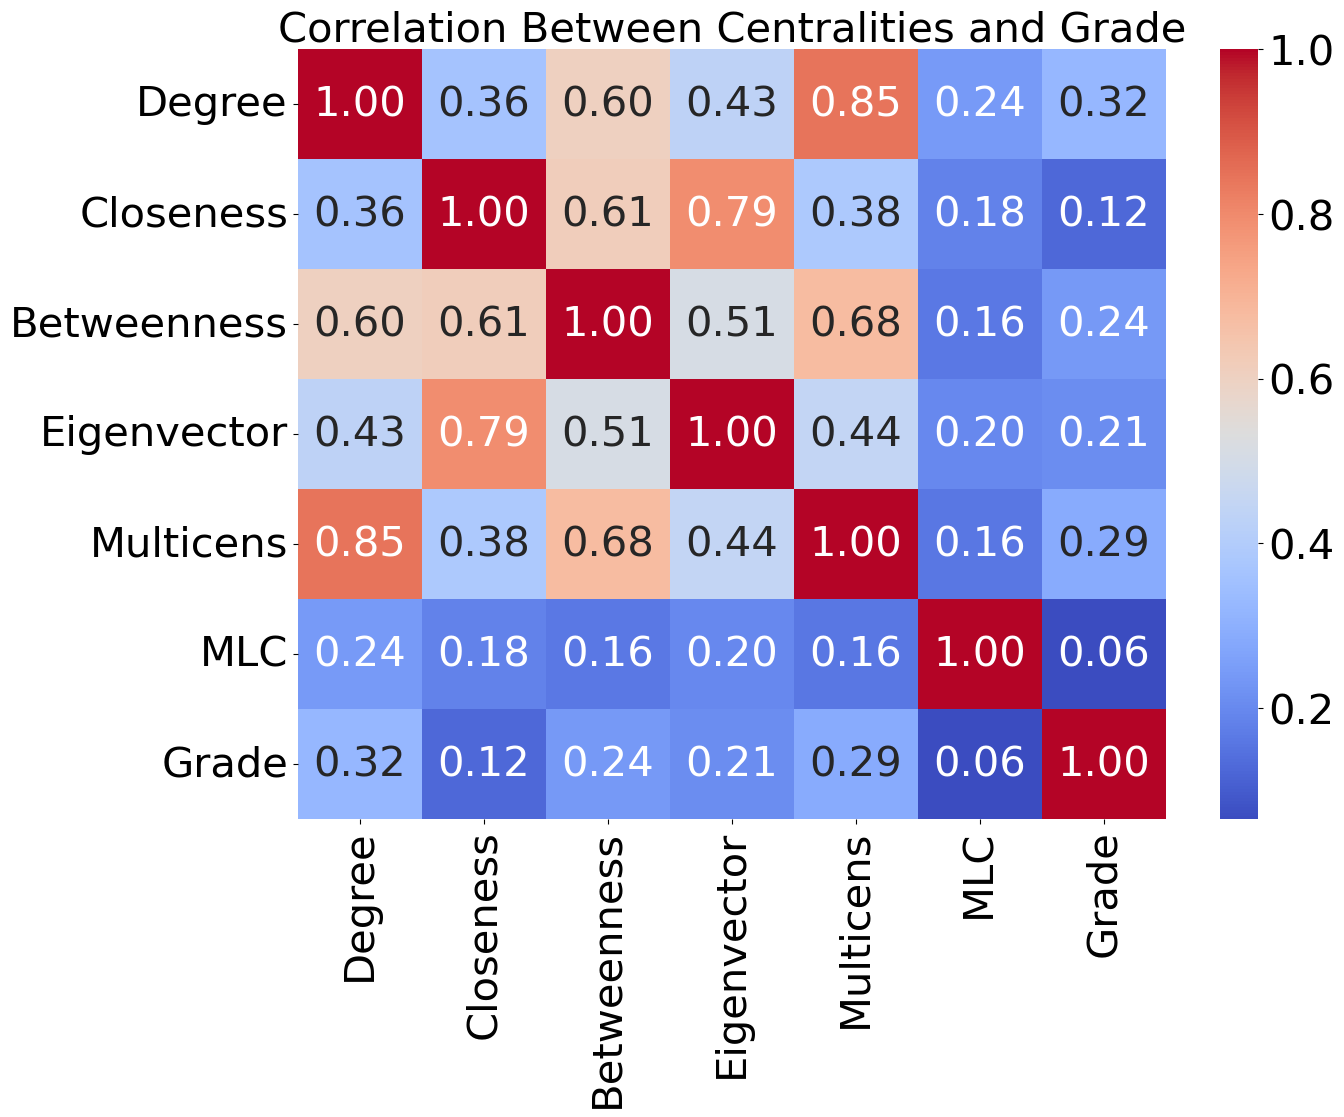

In [962]:
import csv

def getGrade(filename):
    grade = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for _ in range(6):
            next(reader)
        for row in reader:
            grade.append(float(row[-2].split(" ")[-1]))
    return(grade)

folder = "/home/ramanuja-simha/Downloads/consurf/"
print("test")
files = os.listdir(folder)
files.sort()
print(files)

for fn in files:
    fn = files[10]
    print(fn)
    file1 = "/chainA/"
    file2 = "/chainB/"
    # file1 = "clock-bmal1_chainA/"
    # file2 = "clock-bmal1_chainB/"
    fnA = folder+fn+file1+"msa_aa_variety_percentage.csv"
    fnB = folder+fn+file2+"msa_aa_variety_percentage.csv"
    gradeA = getGrade(fnA)
    gradeB = getGrade(fnB)
    grade = gradeA + gradeB
    grade = [x/100 for x in grade]
    # print(grade)
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    df1 = pd.DataFrame({
        "Degree": d,
        "Closeness": c,
        "Betweenness": b,
        "Eigenvector": e,
        "Multicens": m,
        "MLC": new,
        # "Newest": metric,
        "Grade": grade  # Your reference measure (e.g., conservation score)
    })
    
    # # Create scatter plots
    # fig, axes = plt.subplots(1, 6, figsize=(20, 4), sharey=True)
    # for i, col in enumerate(df1.columns[:-1]):  # Ignore "Grade"
    #     sns.scatterplot(x=df1[col], y=df1["Grade"], ax=axes[i], alpha=0.6)
    #     axes[i].set_title(f"{col} vs. Grade")
    #     axes[i].set_xlabel(col)
    #     axes[i].set_ylabel("Grade" if i == 0 else "")
    
    # plt.tight_layout()
    # plt.show()
    
    plt.figure(figsize=(14, 10))
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    corr_matrix = df1.corr(method="spearman")  # "pearson" for linear, "spearman" for ranking-based
    ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 30})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    plt.title("Correlation Between Centralities and Grade", fontsize=30)
    plt.savefig("fig38-sim2_arnt-corr", dpi=300, bbox_inches='tight')
    plt.show()
    
    # sns.jointplot(x="New", y="Grade", data=df1, kind="hex", color="blue")
    
    # df2 = pd.DataFrame({
    #     "Degree": d,
    #     "Closeness": c,
    #     "Betweenness": b,
    #     "Eigenvector": e,
    #     "Multicens": m,
    #     "New": new,
    #     # "Newest": metric,
    # })
    
    # sns.pairplot(df2)
    break

In [1432]:
print(sequences[0])

KDKAKRVSRNKSEKKRRDQFNVLIKELGSMLPGNARKMDKSTVLQKSIDFLRKHKEITAQSDASEIRQDWKPTFLSNEEFTQLMLEALDGFFLAIMTDGSIIYVSESVTSLLEHLPSDLVDQSIFNFIPEGEHSEVYKILSTHLLESDSLTPEYLKSKNQLEFCCHMLRGTIDPKEPSTYEYVKFIGNFKSLNSVSSSAHNGFEGTIQRTHRPSYEDRVCFVATVRLATPQFIKEMCTVEEPNEEFTSRHSLEWKFLFLDHRAPPIIGYLPFEVLGTSGYDYYHVDDLENLAKCHEHLMQYGKGKSCYYRFLTKGQQWIWLQTHYYITYHQWNSRPEFIVCTHTVVSYAEVRAERIKNAREAHSQIEKRRRDKMNSFIDELASLVPTCNAMSRKLDKLTVLRMAVQHMKTLRGATNPYTEANYKPTFLSDDELKHLILRAADGFLFVVGCDRGKILFVSESVFKILNYSQNDLIGQSLFDYLHPKDIAKVKEQLSSSDTAPRERLIDAKTGLPVKTDITPGPSRLCSGARRSFFCRMKCNRPSVKVEDKDFPSTCSKKKADRKSFCTIHSTGYLKSWPPTKMGLDEDNEPDNEGCNLSCLVAIGRLHSHVVPQPVNGEIRVKSMEYVSRHAIDGKFVFVDQRATAILAYLPQELLGTSCYEYFHQDDIGHLAECHRQVLQTREKITTNCYKFKIKDGSFITLRSRWFSFMNPWTKEVEYIVSTNTVVL


[241, 100, 1270, 211, 325, 1083, 235, 101, 1312, 304, 306, 212, 119, 1069]
[1069, 1239, 185, 1240, 211, 212, 213, 1071, 186, 1241, 183, 184, 1204, 1202]
[211, 93, 100, 212, 94, 210, 101, 186, 1069, 92, 1068, 209, 95, 213]
[270, 1261, 162, 1069, 286, 127, 331, 1240, 288, 120, 43, 181, 1346, 211]
[1134, 1133, 1135, 86, 226, 1069, 28, 1068, 1060, 1033, 1206, 18, 222, 1132]
[1287, 211, 34, 116, 328, 1335, 187, 209, 1270, 1278, 113, 1207, 115, 1088]


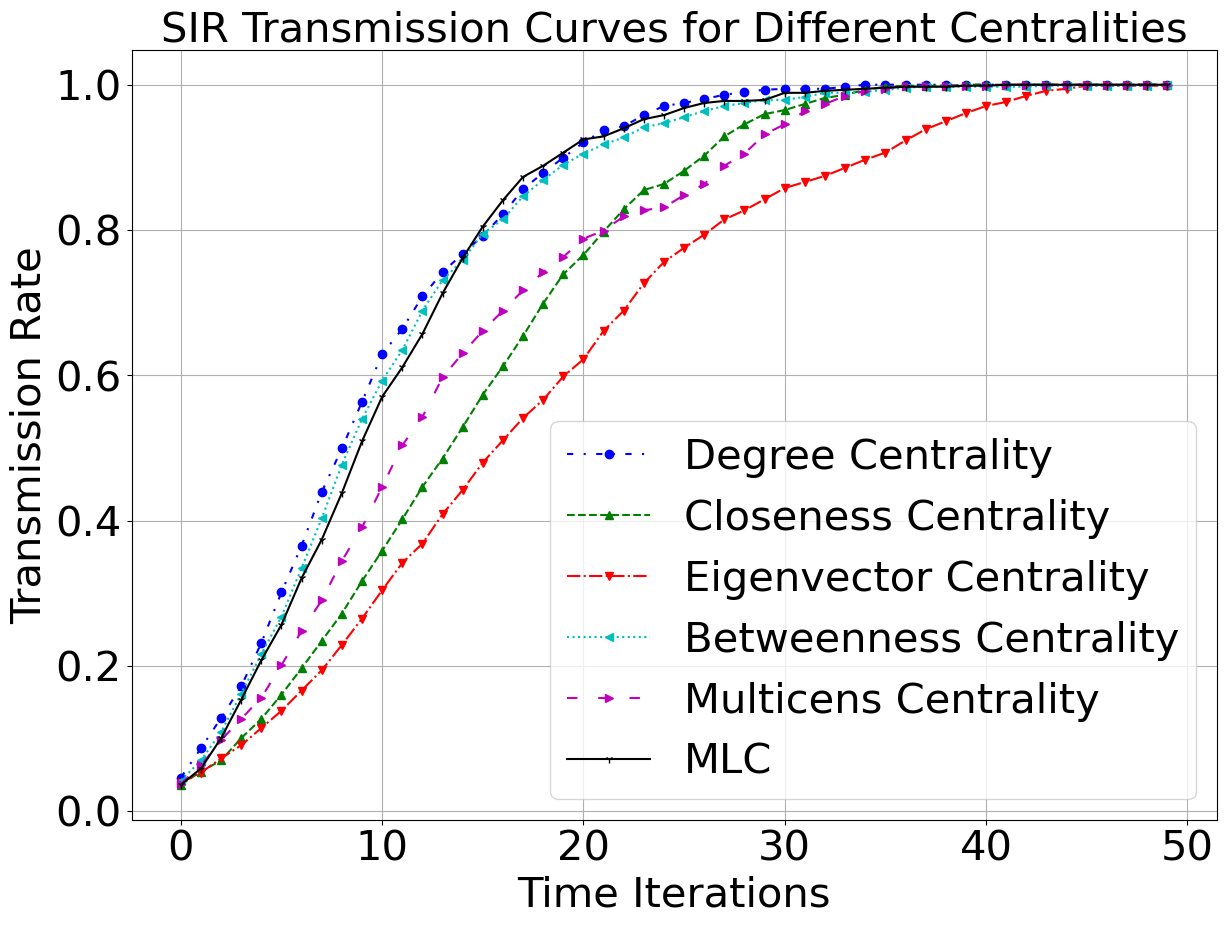

In [940]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
rng = np.random.RandomState(seed)

def get_sorted_centrality(df, graph_name, centrality_col):
    # print(df.columns)
    graph_df = df[df["graph"] == graph_name]
    sorted_graph_df = graph_df.sort_values(by="node")
    sorted_centrality_values = sorted_graph_df[centrality_col].to_numpy()
    return sorted_centrality_values

graph_name = "graph0"  # Replace with the desired graph
centrality_col = "degree"  # Replace with the desired centrality metric
d = get_sorted_centrality(df, graph_name, centrality_col)
# print(d)
centrality_col = "closeness"  # Replace with the desired centrality metric
c = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "betweenness"  # Replace with the desired centrality metric
b = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "eigenvector"  # Replace with the desired centrality metric
e = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "multicens"  # Replace with the desired centrality metric
m = get_sorted_centrality(df, graph_name, centrality_col)
centrality_col = "new"  # Replace with the desired centrality metric
new = get_sorted_centrality(df, graph_name, centrality_col)
# centrality_col = "metric"  # Replace with the desired centrality metric
# metric = get_sorted_centrality(df, graph_name, centrality_col)


# nodes = list(g.nodes())
# nodes.sort()

# Create a sample network (replace with your own graph)
# G = nx.erdos_renyi_graph(1000, 0.05)  # Example: 1000 nodes, 5% edge probability
G = graphs[0]
# Compute centrality measures (Degree, Betweenness, Closeness)
# degree_centrality = nx.degree_centrality(G)
# betweenness_centrality = nx.betweenness_centrality(G)
# closeness_centrality = nx.closeness_centrality(G)

# degree_centrality = d
# closeness_centrality = c
# eigenvector_centrality = e
# betweenness_centrality = b
# multicens_centrality = m
# multilayer_centrality = new
# print(normalized_scores)

# mlc = np.load('mlc.npy')


# Function to simulate SIR dynamics for a given centrality measure
def simulate_SIR(centrality, beta=0.1, gamma=0.1, time_steps=50):
    # sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
    # top_1_percent_nodes = [node for node, _ in sorted_nodes[:int(0.01 * len(G))]]
    
    top_1_percent_count = int(0.02 * len(centrality))  # Calculate 1% of the total nodes
    top_1_percent_nodes = np.argsort(centrality)[::-1][:top_1_percent_count]  # Get indices of top 1% nodes
    res = [(y - 354)+1000 if y > 354 else y for y in top_1_percent_nodes]
    print(res)

    susceptible = set(G.nodes)  # Initially all nodes are susceptible
    infected = set(top_1_percent_nodes)  # Top 1% nodes as initially infected
    recovered = set()  # Initially no recovered nodes
    infected_over_time = []  # To track the number of infected nodes over time

    # r = []
    # Simulation of SIR dynamics
    for t in range(time_steps):
        new_infected = set()
        for node in infected:
            neighbors = set(G.neighbors(node))  # Get neighbors of infected nodes
            for neighbor in neighbors:
                if neighbor in susceptible:
                    # Infection occurs with probability beta
                    # x = np.random.rand()
                    x = rng.rand()
                    # r.append(x)
                    if x < beta:
                        new_infected.add(neighbor)
        
        # Update SIR states
        infected = infected.union(new_infected)
        recovered = recovered.union(infected)
        susceptible = susceptible.difference(infected)
        
        # Track the number of infected nodes
        infected_over_time.append(len(infected) / len(G))
    # print(r)
    return infected_over_time

# Run the SIR model for each centrality (same transmission rate)
degree_transmission = simulate_SIR(d)
closeness_transmission = simulate_SIR(c)
eigenvector_transmission = simulate_SIR(e)
betweenness_transmission = simulate_SIR(b)
multicens_transmission = simulate_SIR(m)
multilayer_transmission = simulate_SIR(new)
# multilayer2_transmission = simulate_SIR(metric)
# [322 694 648 479 478 713 703]

# Plotting the SIR transmission curves for each centrality
plt.figure(figsize=(14, 10))

# Plot each centrality's transmission curve
plt.plot(degree_transmission, linestyle=(0, (3, 5, 1, 5)), label="Degree Centrality", color='b', marker='o')
plt.plot(closeness_transmission, linestyle='--', label="Closeness Centrality", color='g', marker='^')
plt.plot(eigenvector_transmission, linestyle='-.', label="Eigenvector Centrality", color='r', marker='v')
plt.plot(betweenness_transmission, linestyle=':', label="Betweenness Centrality", color='c', marker='<')
plt.plot(multicens_transmission, linestyle=(0, (5, 10)), label="Multicens Centrality", color='m', marker='>')
plt.plot(multilayer_transmission, linestyle='-', label="MLC", color='k', marker='1')
# plt.plot(multilayer2_transmission, label="Newest", color='y', marker='s')


# Mark the steady-state region (same steady state for all centralities since same transmission rate)
# plt.axhline(y=max(degree_transmission), color='b', linestyle='--', label='Steady State')

# Labels and title
plt.xlabel("Time Iterations", fontsize=30)
plt.ylabel("Transmission Rate", fontsize=30)
plt.title("SIR Transmission Curves for Different Centralities", fontsize=30)
# plt.xlim(1, 30)
# plt.xticks(np.arange(0, 30, 5))
# plt.ylim(0, 1)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.grid(True)
plt.savefig("fig27-sim2_arnt-k2top2", dpi=300, bbox_inches='tight')
plt.show()

# [322 694 648 479 478 713 703]
# [322 648 694 479 478 425 644]

Degree Removal -> Avg. Shortest Path: 9.76, Components: 1
Closeness Removal -> Avg. Shortest Path: 11.70, Components: 1
Eigenvector Removal -> Avg. Shortest Path: 10.13, Components: 1
Betweenness Removal -> Avg. Shortest Path: 10.98, Components: 1
Multicens Removal -> Avg. Shortest Path: 9.77, Components: 1
New Removal -> Avg. Shortest Path: 9.38, Components: 1


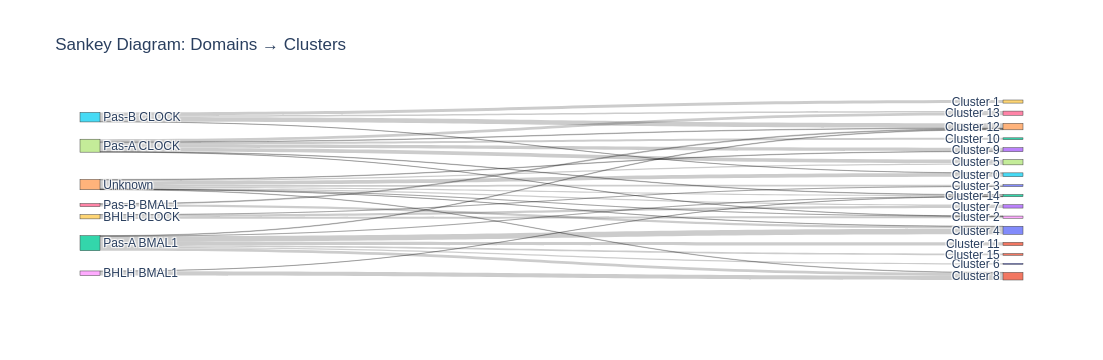

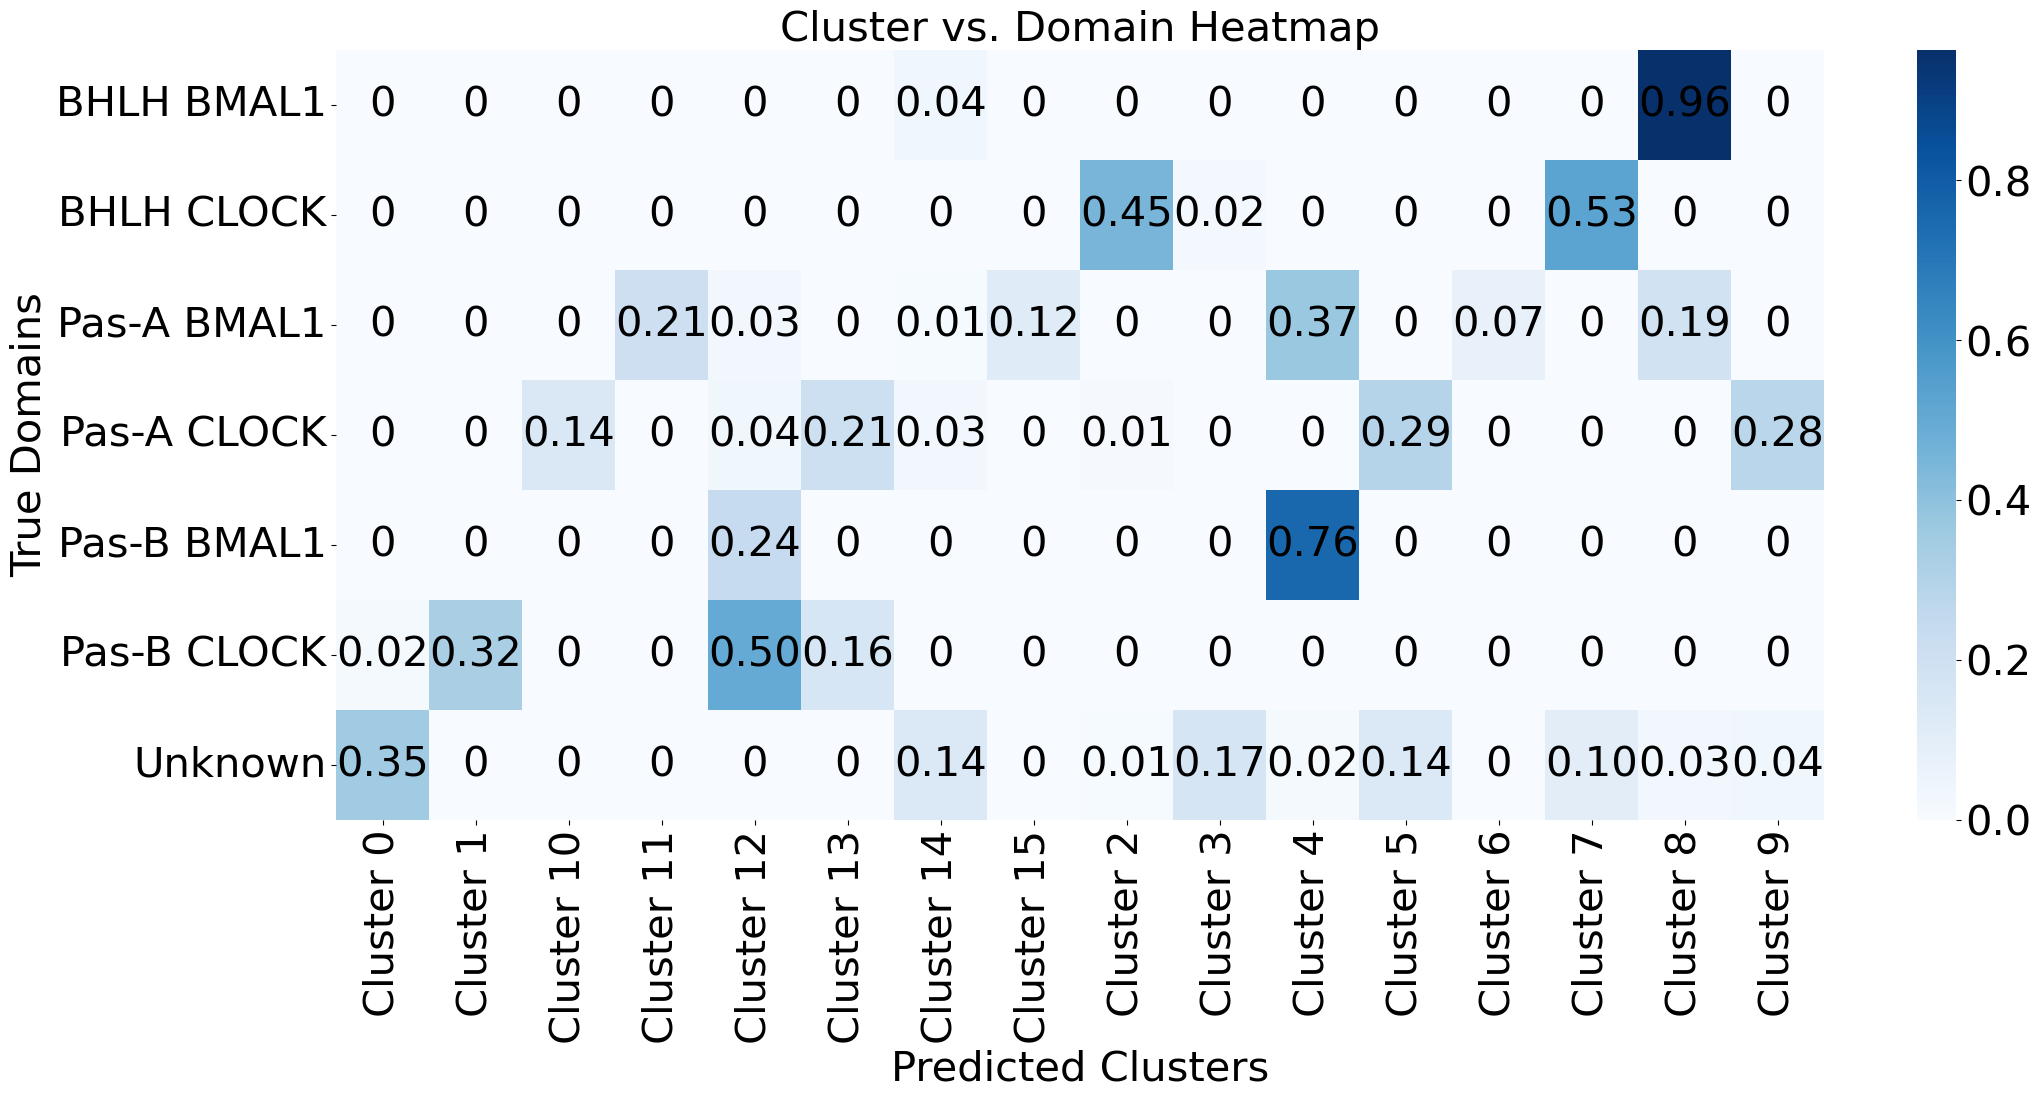

In [972]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import networkx as nx
import community  # Install with: pip install python-louvain
import matplotlib.pyplot as plt
from collections import Counter

def get_dist(g, node_scores):
    G = g.copy()
    ranks = {node: rank for rank, node in enumerate(sorted(node_scores, key=node_scores.get, reverse=True), start=1)}
    # print(ranks)
    # Compute weight based on rank distance
    max_rank = max(ranks.values())
    for u, v in G.edges():
        G[u][v]['weight'] = 1 - (abs(ranks[u] - ranks[v]) / max_rank)
    return(G)
# print(multilayer_centrality)
G = get_dist(g, multicens_centrality)
# print(eigenvector_centrality)


partition = community.best_partition(G, weight="weight")

# Define node domains (ground truth)
domain1 = set(range(34, 85))
domain2 = set(range(110, 265))
domain3 = set(range(265, 379))
domain4 = set(range(425, 480))
domain5 = set(range(497, 678))
domain6 = set(range(680, 729))

domain_labels = {}
for node in G.nodes():
    if node in domain1:
        domain_labels[node] = "BHLH CLOCK"
    elif node in domain2:
        domain_labels[node] = "Pas-A CLOCK"
    elif node in domain3:
        domain_labels[node] = "Pas-B CLOCK"
    elif node in domain4:
        domain_labels[node] = "BHLH BMAL1"
    elif node in domain5:
        domain_labels[node] = "Pas-A BMAL1"
    elif node in domain6:
        domain_labels[node] = "Pas-B BMAL1"
    else:
        domain_labels[node] = "Unknown"

import pandas as pd
import plotly.graph_objects as go

# Count transitions from domains to clusters
transition_counts = Counter((domain_labels[node], f"Cluster {partition[node]}") for node in G.nodes())

# Convert to DataFrame
df = pd.DataFrame(transition_counts.items(), columns=["Transition", "Count"])
df[["Source", "Target"]] = pd.DataFrame(df["Transition"].tolist(), index=df.index)

# Generate Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        label=list(set(df["Source"]) | set(df["Target"])),
        pad=20,
    ),
    link=dict(
        source=[list(set(df["Source"]) | set(df["Target"])).index(src) for src in df["Source"]],
        target=[list(set(df["Source"]) | set(df["Target"])).index(tgt) for tgt in df["Target"]],
        value=df["Count"]
    )
))

fig.update_layout(title_text="Sankey Diagram: Domains → Clusters", font_size=12)
fig.show()

# List domain and cluster labels
unique_domains = sorted(set(domain_labels.values()))
unique_clusters = sorted(set(f"Cluster {c}" for c in set(partition.values())))

# Create a confusion matrix
confusion_matrix = np.zeros((len(unique_domains), len(unique_clusters)))

# Populate matrix
for node in G.nodes():
    true_domain_idx = unique_domains.index(domain_labels[node])
    predicted_cluster_idx = unique_clusters.index(f"Cluster {partition[node]}")
    confusion_matrix[true_domain_idx, predicted_cluster_idx] += 1

# Normalize rows (optional)
cm = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# Plot heatmap
plt.figure(figsize=(24, 10))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax = sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=unique_clusters, yticklabels=unique_domains, fmt=".2f", annot_kws={"size": 30})
ax = sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=unique_clusters, yticklabels=unique_domains, fmt=".2f", annot_kws={"size": 30})

def format_value(value):
    if value == 0:
        return "0"
    elif value.is_integer():  # Check if it's a whole number
        return f"{int(value)}"  # Convert to integer string (removes .0)
    else:
        return f"{value:.2f}"  # Keep two decimal places for non-integer values

# Add formatted annotations manually as strings
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        formatted_text = format_value(cm[i, j])  # Ensure annotation is always a string
        ax.text(j + 0.5, i + 0.5, formatted_text, ha="center", va="center", color="black", fontsize=30)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.xlabel("Predicted Clusters", fontsize=30)
plt.ylabel("True Domains", fontsize=30)
plt.title("Cluster vs. Domain Heatmap", fontsize=30)
plt.savefig("fig39", dpi=300, bbox_inches='tight')
plt.show()